# EDA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE

## 1. Read files and get a broad overview

In [2]:
folder = '/home/olli/Projects/Kaggle/ICR'

In [3]:
os.listdir(folder)

['train.csv',
 'greeks.csv',
 'sample_submission.csv',
 'todo.txt',
 'Notebooks',
 'icr-identify-age-related-conditions.zip',
 'test.csv']

In [4]:
train_csv = 'train.csv'
greek_csv = 'greeks.csv'
test_csv = 'test.csv'

In [5]:
train_csv_path = os.path.join(folder, train_csv)
greek_csv_path = os.path.join(folder, greek_csv)
test_csv_path = os.path.join(folder, test_csv)

In [6]:
df = pd.read_csv(train_csv_path)
df_g = pd.read_csv(greek_csv_path)
df_test = pd.read_csv(test_csv_path)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

Very small dataset with only 617 datapoints

Some columns have a few missing values however BQ & EL have by far the most and the same number (557/617 -> 60missing)

In [8]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [9]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       617 non-null    object
 1   Alpha    617 non-null    object
 2   Beta     617 non-null    object
 3   Gamma    617 non-null    object
 4   Delta    617 non-null    object
 5   Epsilon  617 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


In [10]:
df_g.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [11]:
set(df_g.Id.values) == set(df.Id.values)

True

Additional information for the patients

## 2. Plot some basic histograms for the df to get an intuitions for the distribution

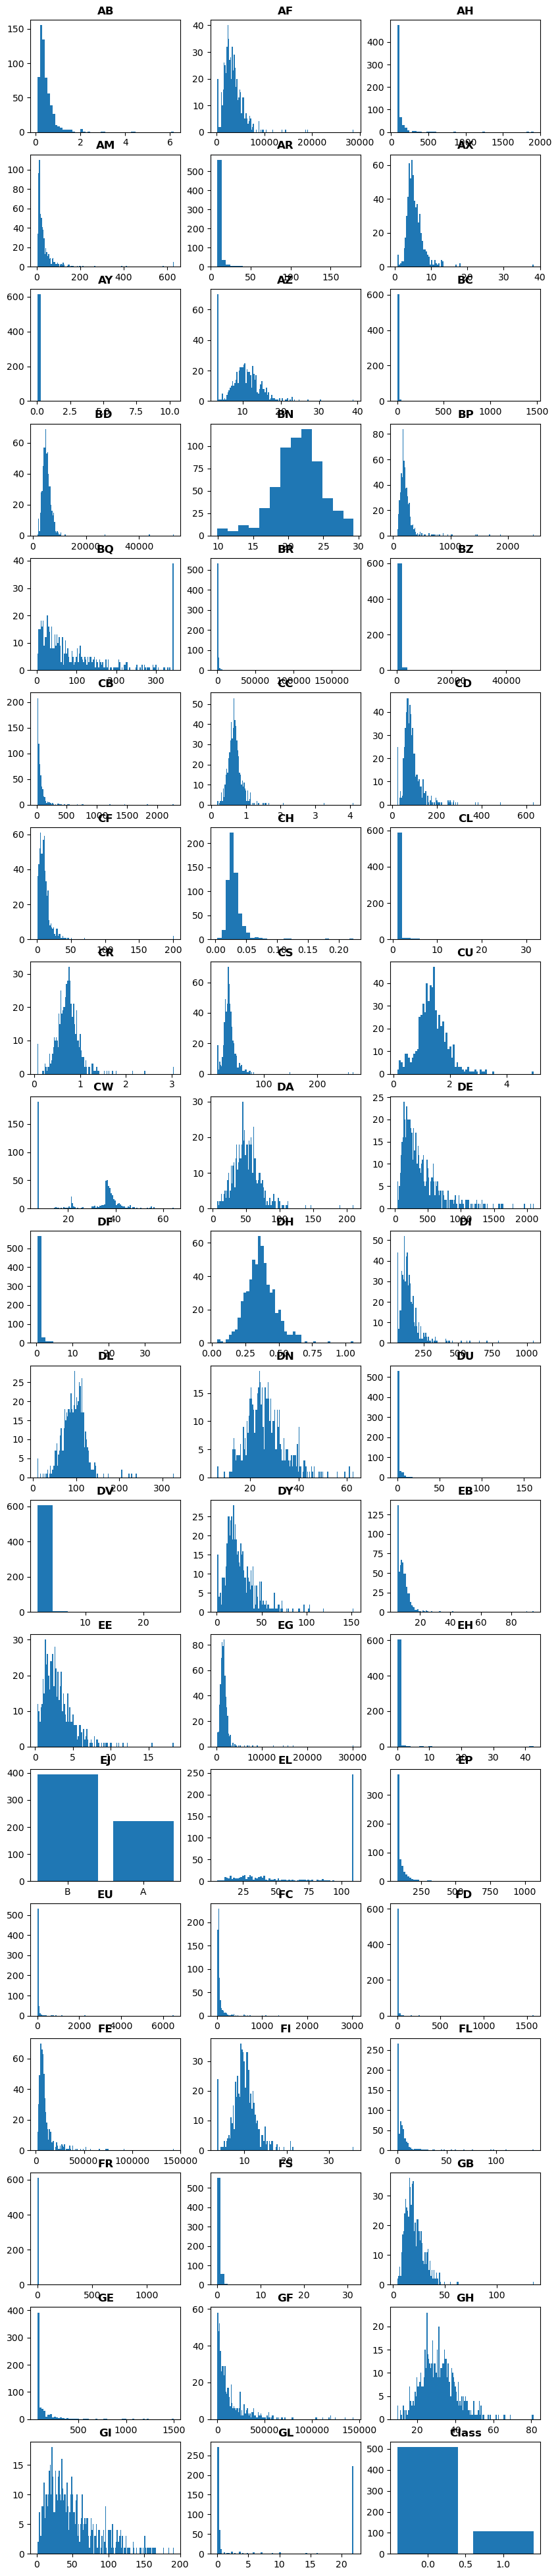

In [12]:
fig, ax = plt.subplots(nrows=19, ncols=3, figsize=(10, 50))

row, col = None, None

for index, col_name in enumerate(df.columns[1:]):  # skip id
    
    if row is None:
        row, col = 0, 0
        
    elif col % 3 == 0:
        col = 0
        row += 1
    
    values = df[col_name].values
    # define the number of bins based on the unique values in a column (usually n/4 or sqrt(4))
    bins = int(len(df[col_name].value_counts()) / 4)
    
    try:
        ax[row, col].hist(values, bins=bins)
        ax[row, col].set_title(f'{col_name}', fontweight='bold')
    except ValueError:  # cant use categorical for hist, make bar instead
        x = df[col_name].value_counts().index
        y = df[col_name].value_counts().values
        ax[row, col].bar(x, y)
        ax[row, col].set_title(f'{col_name}', fontweight='bold')
    
    col += 1

Looking at BQ and EL it looks like a bad idea to impute the many missing values with the median or the mean. Maybe train a model on some features that correlate high with them to then use the model prediction on missing values.

## 3. Check if the extreme outliers have a specific class

In [13]:
def check_outliers(times_std=4, df=df):
    
    df = df.copy()
    
    cols = list(df.columns)
    
    # remove columns that make no sense
    cols.remove('Id')
    cols.remove('Class')
    cols.remove('EJ')
    
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()

        filt_smaller = df[col] < (mean - times_std * std)
        filt_larger = df[col] > (mean + times_std * std)

        new_df = df[filt_smaller | filt_larger]
        
        positive_outliers = len(new_df[new_df['Class'] == 1])
        
        if len(new_df) > 0:    
            print(f'Col: {col}: Outliers: {len(new_df)} - Class 1: {positive_outliers}')

In [14]:
check_outliers()

Col: AB: Outliers: 6 - Class 1: 4
Col: AF: Outliers: 5 - Class 1: 4
Col: AH: Outliers: 4 - Class 1: 2
Col: AM: Outliers: 8 - Class 1: 7
Col: AR: Outliers: 3 - Class 1: 0
Col: AX: Outliers: 4 - Class 1: 3
Col: AY: Outliers: 1 - Class 1: 1
Col: AZ: Outliers: 2 - Class 1: 1
Col: BC: Outliers: 2 - Class 1: 2
Col: BD : Outliers: 3 - Class 1: 3
Col: BP: Outliers: 7 - Class 1: 3
Col: BR: Outliers: 2 - Class 1: 1
Col: BZ: Outliers: 1 - Class 1: 1
Col: CB: Outliers: 6 - Class 1: 1
Col: CC: Outliers: 3 - Class 1: 2
Col: CD : Outliers: 4 - Class 1: 1
Col: CF: Outliers: 3 - Class 1: 2
Col: CH: Outliers: 4 - Class 1: 1
Col: CL: Outliers: 5 - Class 1: 1
Col: CR: Outliers: 4 - Class 1: 0
Col: CS: Outliers: 3 - Class 1: 0
Col: CU: Outliers: 1 - Class 1: 0
Col: DA: Outliers: 4 - Class 1: 0
Col: DE: Outliers: 4 - Class 1: 1
Col: DF: Outliers: 5 - Class 1: 1
Col: DH: Outliers: 2 - Class 1: 0
Col: DI: Outliers: 7 - Class 1: 4
Col: DL: Outliers: 4 - Class 1: 0
Col: DN: Outliers: 4 - Class 1: 3
Col: DU: Out

In [15]:
check_outliers(times_std=10)

Col: AB: Outliers: 1 - Class 1: 1
Col: AF: Outliers: 1 - Class 1: 1
Col: AH: Outliers: 2 - Class 1: 0
Col: AR: Outliers: 2 - Class 1: 0
Col: AX: Outliers: 1 - Class 1: 1
Col: AY: Outliers: 1 - Class 1: 1
Col: BC: Outliers: 1 - Class 1: 1
Col: BD : Outliers: 2 - Class 1: 2
Col: BP: Outliers: 1 - Class 1: 1
Col: BR: Outliers: 1 - Class 1: 1
Col: BZ: Outliers: 1 - Class 1: 1
Col: CB: Outliers: 2 - Class 1: 0
Col: CC: Outliers: 1 - Class 1: 1
Col: CD : Outliers: 1 - Class 1: 1
Col: CF: Outliers: 2 - Class 1: 2
Col: CH: Outliers: 2 - Class 1: 0
Col: CL: Outliers: 2 - Class 1: 0
Col: CS: Outliers: 2 - Class 1: 0
Col: DF: Outliers: 1 - Class 1: 0
Col: DI: Outliers: 1 - Class 1: 0
Col: DU: Outliers: 2 - Class 1: 2
Col: DV: Outliers: 2 - Class 1: 0
Col: EB: Outliers: 2 - Class 1: 0
Col: EG: Outliers: 1 - Class 1: 0
Col: EH: Outliers: 1 - Class 1: 1
Col: EP: Outliers: 2 - Class 1: 0
Col: EU: Outliers: 2 - Class 1: 0
Col: FC: Outliers: 1 - Class 1: 1
Col: FD : Outliers: 1 - Class 1: 1
Col: FE: Ou

Looks like class 1 is overrepresented in the outliers considering the class distribution

## 4. Class distribution

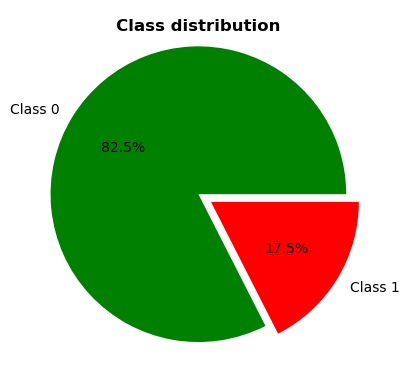

In [16]:
plt.pie(df.Class.value_counts().values,
        explode=[0, 0.1],
        labels=['Class 0', 'Class 1'],
        colors=['g', 'r'],
        autopct='%1.1f%%')
plt.title('Class distribution', y=0.92, fontweight='bold')
plt.show()

Imbalance in the classes, upsampling with weights will be needed

In [17]:
df.Class.value_counts()

0    509
1    108
Name: Class, dtype: int64

In [18]:
# weight for the underrepresented class (1)
weight = 509 / 108
weight

4.712962962962963

## 5. Additional information in the second df

In [19]:
df_g.columns

Index(['Id', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon'], dtype='object')

In [20]:
df_g.Epsilon.value_counts()

Unknown       144
5/29/2019      24
6/26/2019      19
9/15/2020      17
8/29/2019      13
             ... 
2/21/2019       1
8/13/2019       1
5/18/2020       1
12/20/2019      1
7/24/2019       1
Name: Epsilon, Length: 198, dtype: int64

These look like the dates when the data of the patient was taken.

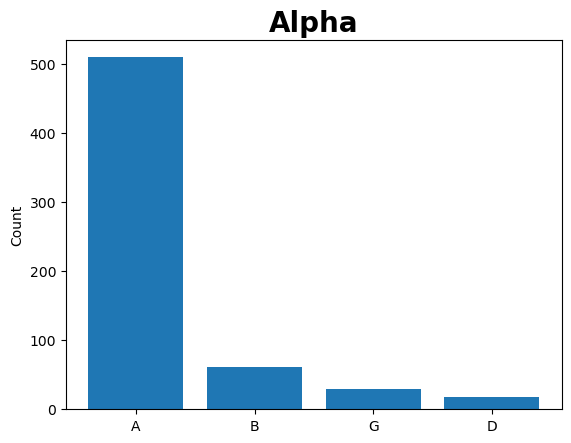

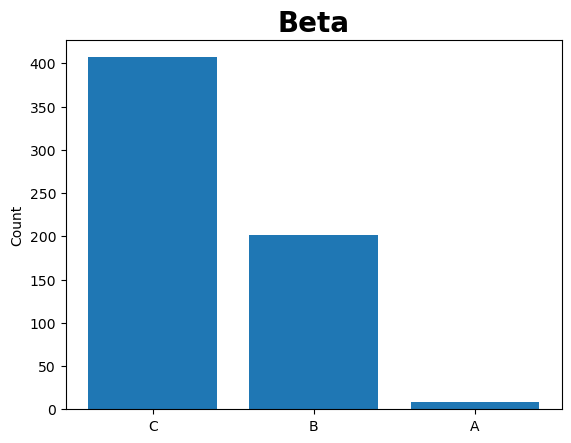

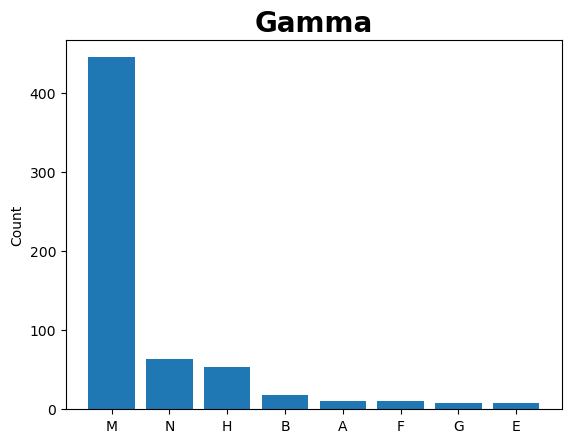

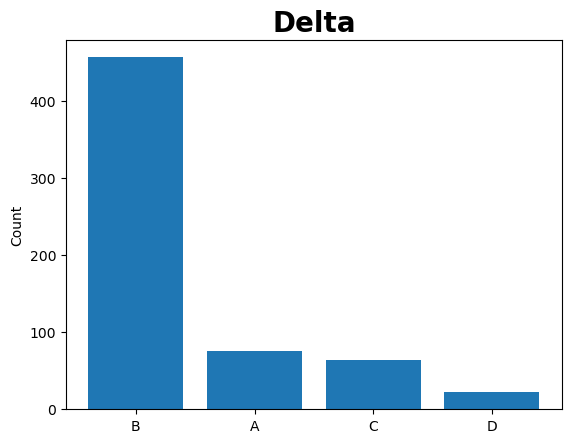

In [21]:
for col in 'Alpha', 'Beta', 'Gamma', 'Delta':
    values = df_g[col].value_counts().index
    counts = df_g[col].value_counts().values

    plt.bar(values, counts)
    plt.title(col, fontsize=20, fontweight='bold')
    plt.ylabel('Count')
    plt.show()

## 6. Combine the 2 dfs and check if the time values have an impact on the class

In [22]:
df_g.columns

Index(['Id', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon'], dtype='object')

In [23]:
df_comb = df.sort_values('Id')
df_2 = df_g.sort_values('Id')
df_comb[['Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon']] = df_2[['Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon']]

In [24]:
df_comb.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'Alpha',
       'Beta', 'Gamma', 'Delta', 'Epsilon'],
      dtype='object')

### First check the Cases with Unknown timestemps

In [25]:
df_comb[df_comb.Epsilon == 'Unknown']['Class'].value_counts()

0    144
Name: Class, dtype: int64

In [26]:
len(df_comb[df_comb.Epsilon == 'Unknown'])

144

All values with Unknown have Class 0!

### Now convert Epsilon to datetime and then plot with histograms with each class separated

In [27]:
df_comb_date = df_comb.copy()
df_comb_date = df_comb_date[df_comb_date.Epsilon != 'Unknown']
df_comb_date['Date'] = pd.to_datetime(df_comb_date.Epsilon, format='%m/%d/%Y')

In [28]:
len(df_comb_date)

473

Text(0.5, 1.0, 'Class 1')

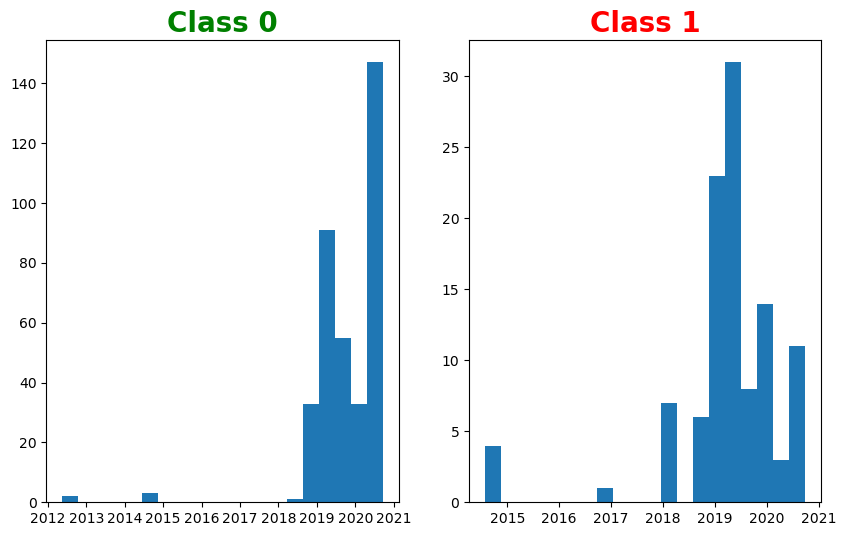

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
class_0 = df_comb_date[df_comb_date.Class == 0]
class_1 = df_comb_date[df_comb_date.Class == 1]

ax[0].hist(class_0.Date, bins=20)
ax[1].hist(class_1.Date, bins=20)
ax[0].set_title('Class 0', fontsize=20, fontweight='bold', c='g')
ax[1].set_title('Class 1', fontsize=20, fontweight='bold', c='r')

Looks like only the ealier points might be useful, they are very few tho

## 7. Correlate the features with the Target

In [30]:
df_num = df.drop(['Id', 'EJ'], axis=1)
target = df_num.pop('Class')

In [31]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

## 8. Feature Correlation

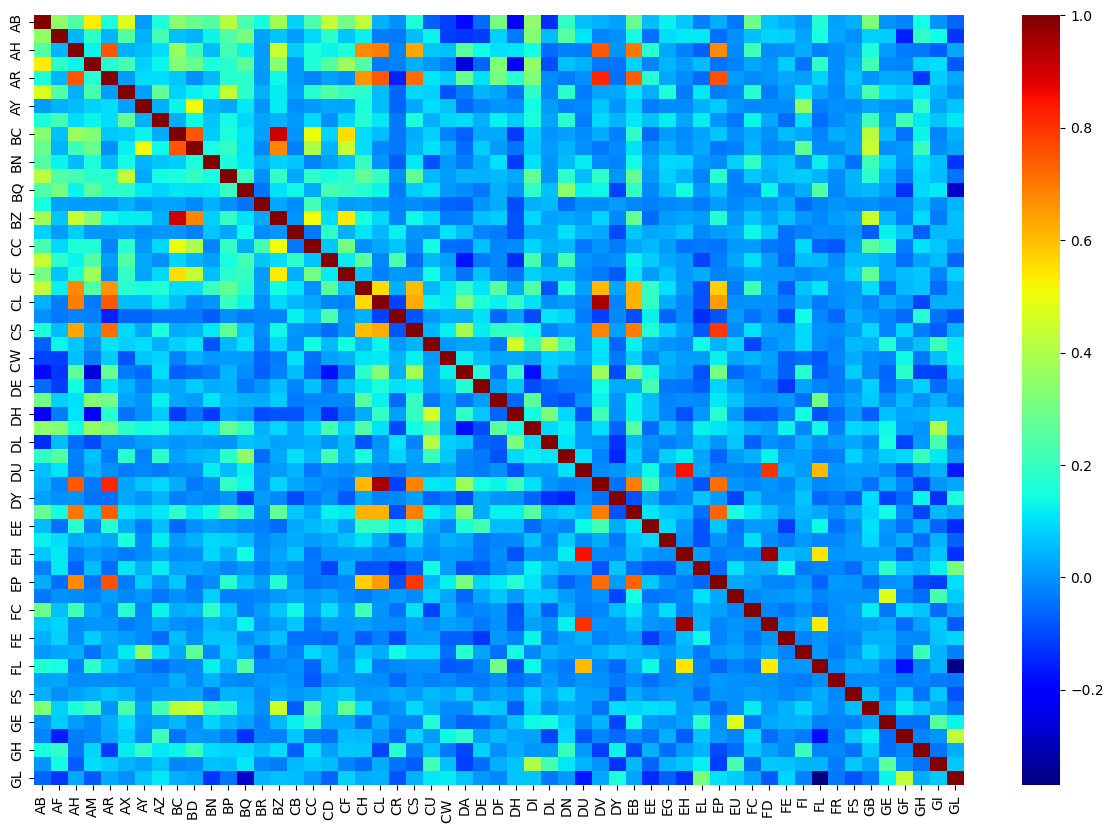

In [32]:
plt.figure(figsize=(15,10))
sns.heatmap(df_num.corr(), cmap='jet')
plt.show()

Sadly BQ and EL are not correlating high with other features

## 9. Target correlation

In [33]:
df_num.corrwith(target).sort_values(ascending=False)

AF     0.302638
BQ     0.281257
AB     0.280612
DU     0.261000
DI     0.260760
FL     0.244185
AM     0.239170
FE     0.216359
BN     0.198283
EH     0.179855
CD     0.171304
BP     0.157286
BC     0.155882
FD     0.131100
BZ     0.112423
BD     0.112184
CF     0.109748
FR     0.104099
AX     0.097616
BR     0.088554
EB     0.088005
GB     0.083343
AY     0.082420
GI     0.076894
EL     0.067947
AR     0.064380
DF     0.064272
DY     0.062734
AH     0.044645
GH     0.033540
FC     0.030689
CL     0.016852
DV     0.015477
AZ     0.013516
CH     0.008144
FS     0.001139
DN    -0.008478
CB    -0.014777
EG    -0.024610
EU    -0.039739
CS    -0.047438
CC    -0.054723
CW    -0.062639
EP    -0.068383
GE    -0.070766
CU    -0.083185
FI    -0.094327
GL    -0.119202
DE    -0.124977
GF    -0.128208
EE    -0.135324
DL    -0.147716
DA    -0.204612
DH    -0.206839
CR    -0.227547
dtype: float64

BQ has quite a high correlation with the target compared to the other features so a good imputer should be useful

## 10. Same for the categorical features (encode them first)

In [34]:
df_cat = df_g.copy()

In [35]:
# add the categorical feature from df
df_cat['EJ'] = df['EJ']

In [36]:
df_cat.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon,EJ
0,000ff2bfdfe9,B,C,G,D,3/19/2019,B
1,007255e47698,A,C,M,B,Unknown,A
2,013f2bd269f5,A,C,M,B,Unknown,B
3,043ac50845d5,A,C,M,B,Unknown,B
4,044fb8a146ec,D,B,F,B,3/25/2020,B


In [37]:
df_cat.drop(['Id', 'Epsilon'], axis=1, inplace=True)

In [38]:
encoder = OneHotEncoder(sparse_output=False)

In [39]:
cat_onehot = encoder.fit_transform(df_cat)

In [40]:
cat_onehot.shape

(617, 21)

21 is correct as can be seen in the plots above; now create the col names

In [41]:
col_names = encoder.get_feature_names_out()

In [42]:
col_names

array(['Alpha_A', 'Alpha_B', 'Alpha_D', 'Alpha_G', 'Beta_A', 'Beta_B',
       'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E', 'Gamma_F', 'Gamma_G',
       'Gamma_H', 'Gamma_M', 'Gamma_N', 'Delta_A', 'Delta_B', 'Delta_C',
       'Delta_D', 'EJ_A', 'EJ_B'], dtype=object)

In [43]:
df_cat_onehot = pd.DataFrame(cat_onehot, columns=col_names)

In [44]:
df_cat_onehot.corrwith(target).sort_values(ascending=False)

Alpha_B    0.719076
Gamma_H    0.665496
Alpha_G    0.482122
Alpha_D    0.376331
Gamma_B    0.376331
Gamma_A    0.292487
Gamma_F    0.278646
Gamma_E    0.248819
Gamma_G    0.248819
Beta_A     0.248819
Beta_B     0.169435
Delta_D    0.164436
Delta_A    0.128851
Delta_C    0.123060
EJ_B       0.096500
EJ_A      -0.096500
Gamma_N   -0.156704
Beta_C    -0.227207
Delta_B   -0.250755
Gamma_M   -0.740916
Alpha_A   -1.000000
dtype: float64

The supplemental data is not available for the test data. Alpha in this case defines the target in more detail (A=0, B=G=D=1).

Gamma M  might be a useful addition since this by far the most frequent one in Gamma

## 11. Dimension reduction to plot the data 2D with the class as a color

For now encode the missing values with the median and encode the one categorical feature

In [45]:
df_plot = df.copy()

In [46]:
df_plot.EJ = df_plot.EJ.apply(lambda x: 0 if x == 'A' else 1)

In [47]:
df_plot.EJ.value_counts()

1    395
0    222
Name: EJ, dtype: int64

In [48]:
df_plot = df_plot.drop(['Id', 'Class'], axis=1)

In [49]:
df_plot.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')

In [50]:
imputer = SimpleImputer(strategy='median')

In [51]:
X = imputer.fit_transform(df_plot)

### First use a PCA

In [52]:
pca = PCA(n_components=2)

In [53]:
X_pca = pca.fit_transform(X)

In [54]:
X_pca.shape

(617, 2)

In [55]:
df_pca = pd.DataFrame(X_pca, columns=['Principal_Component_1', 'Principal_Component_2'])

In [56]:
# Create 2 Plots: One with all subclasses as one and one with more detail
df_pca['Target'] = df.Class
df_pca['Alpha'] = df_g.Alpha

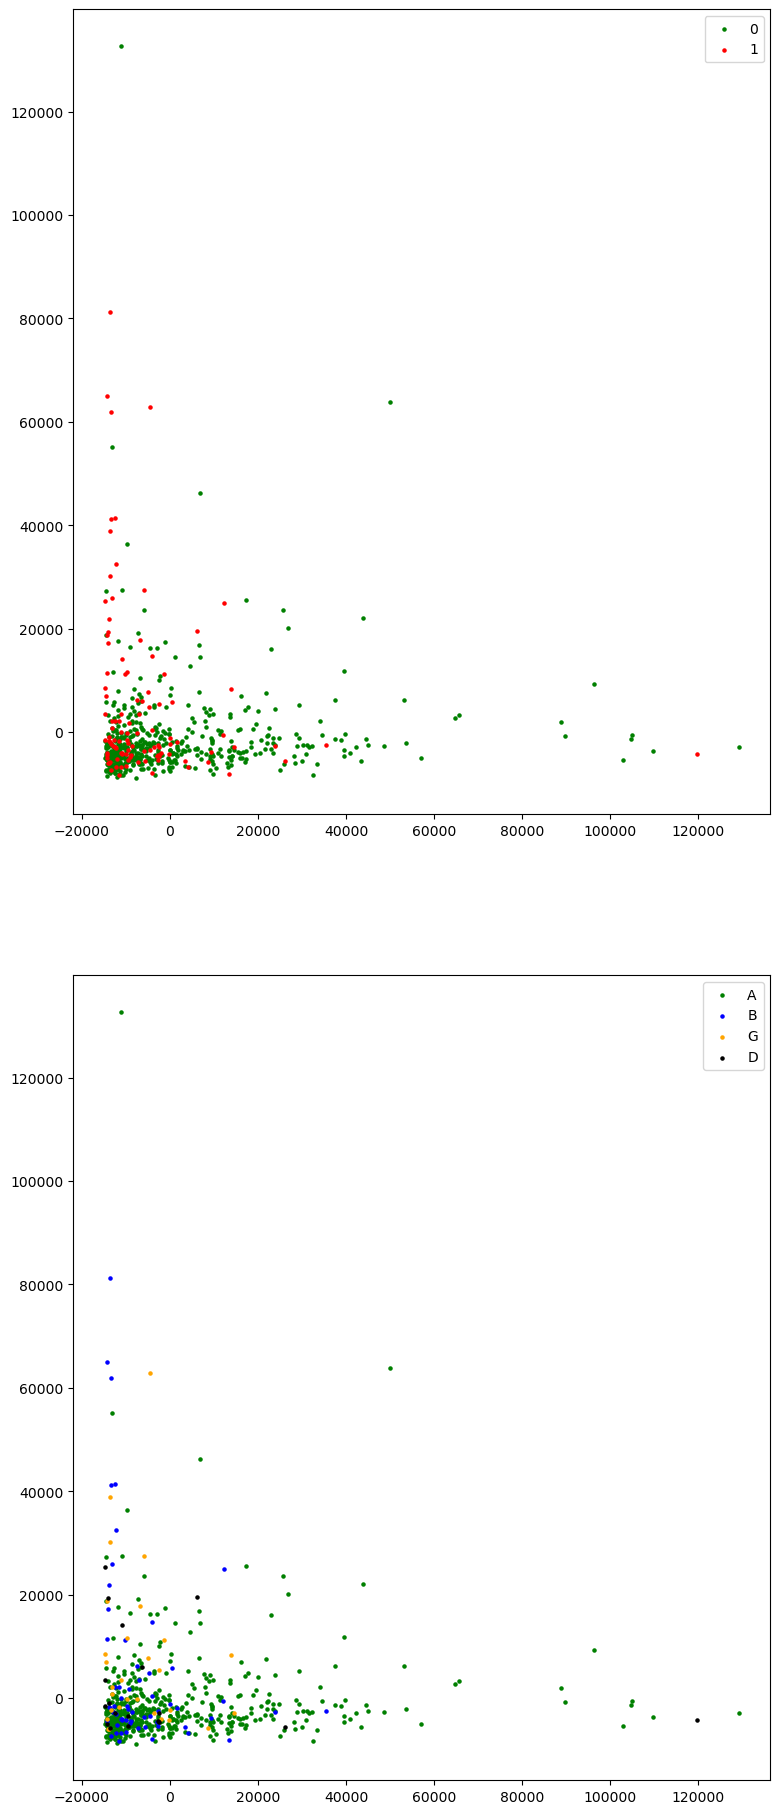

In [57]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 23))

c_target = {0: 'g', 1: 'r'}
target_values = df_pca.Target.value_counts().index

for value in target_values:
    df_filt = df_pca[df_pca.Target == value]
    ax[0].scatter(df_filt.Principal_Component_1, df_filt.Principal_Component_2, c=c_target[value], s=5, label=value)
ax[0].legend()

c_alpha = {'A': 'green', 'B': 'blue',  'G': 'orange',  'D': 'black'}
alpha_values = df_pca.Alpha.value_counts().index

for value in alpha_values:
    df_filt = df_pca[df_pca.Alpha == value]
    ax[1].scatter(df_filt.Principal_Component_1, df_filt.Principal_Component_2, c=c_alpha[value], s=5, label=value)
ax[1].legend()

plt.show()

### Same with t-SNE

In [58]:
tsne = TSNE(n_components=2)

In [59]:
X_tsne = tsne.fit_transform(X=X)

In [60]:
X_tsne.shape

(617, 2)

In [61]:
df_tsne = pd.DataFrame(X_tsne, columns=['Principal_Component_1', 'Principal_Component_2'])

In [62]:
# Create 2 Plots: One with all subclasses as one and one with more detail
df_tsne['Target'] = df.Class
df_tsne['Alpha'] = df_g.Alpha

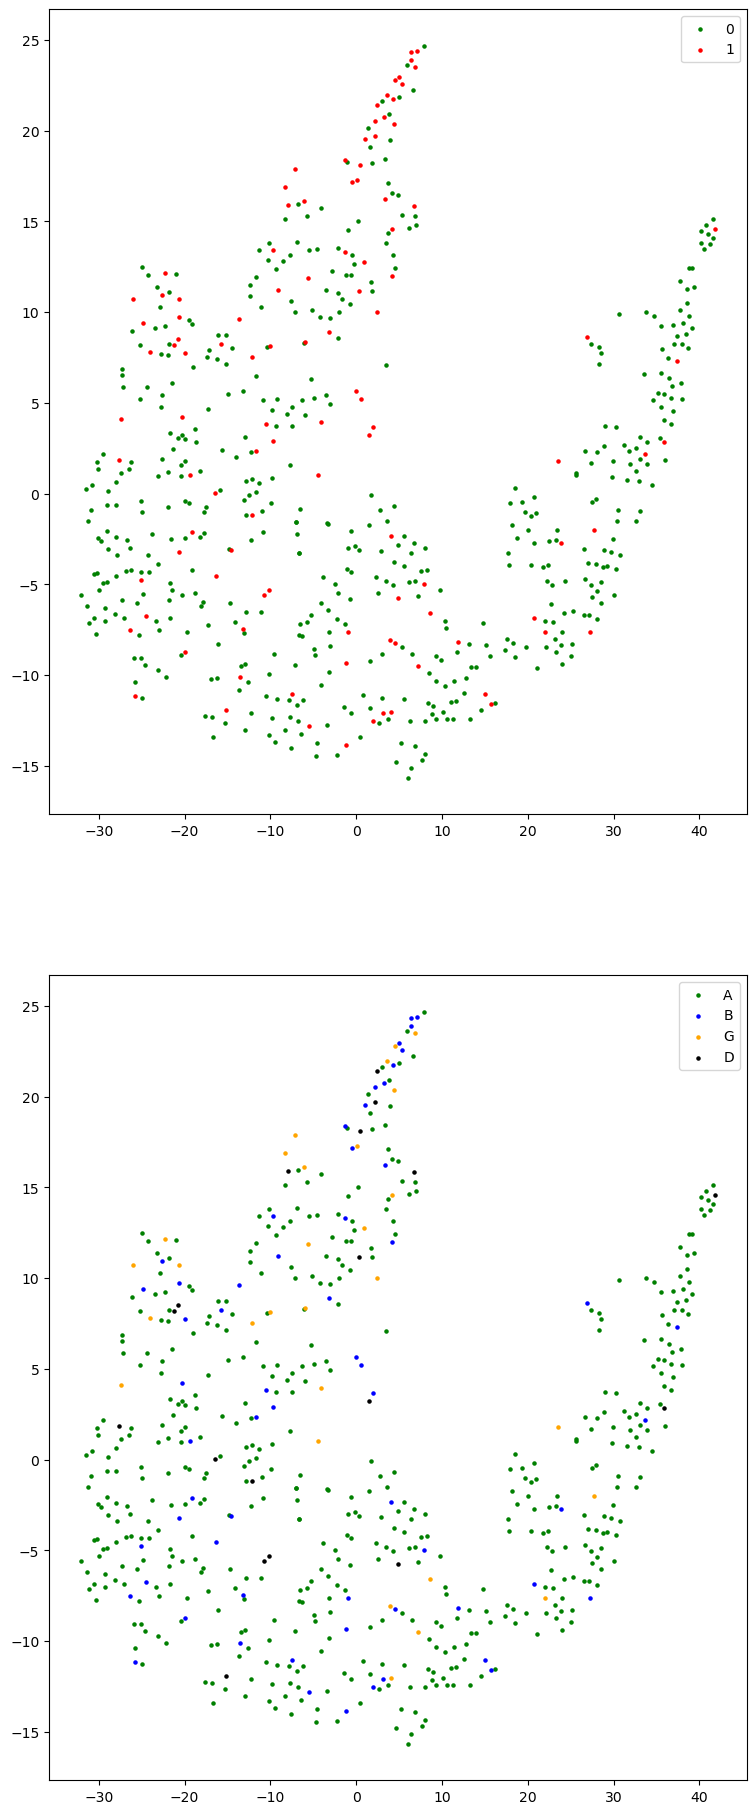

In [63]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 23))

c_target = {0: 'g', 1: 'r'}
target_values = df_tsne.Target.value_counts().index

for value in target_values:
    df_filt = df_tsne[df_tsne.Target == value]
    ax[0].scatter(df_filt.Principal_Component_1, df_filt.Principal_Component_2, c=c_target[value], s=5, label=value)
ax[0].legend()

c_alpha = {'A': 'green', 'B': 'blue',  'G': 'orange',  'D': 'black'}
alpha_values = df_tsne.Alpha.value_counts().index

for value in alpha_values:
    df_filt = df_tsne[df_tsne.Alpha == value]
    ax[1].scatter(df_filt.Principal_Component_1, df_filt.Principal_Component_2, c=c_alpha[value], s=5, label=value)
ax[1].legend()

plt.show()